## 라이브러리 호출

In [1]:
from urllib.request import Request, urlopen
from urllib.parse import unquote, urlencode, quote_plus

In [71]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## API KEY

In [36]:
key = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D'

## 로그

In [3]:
import time

In [114]:
print("[시작] {}".format(time.ctime()), end='')

[시작] Thu Jan 28 16:36:42 2021

In [5]:
#TODO로그작성
"""
[종료] Wed Jan 27 15:23:08 2021
(SOLVED)stationNo가 존재 하지 않는 경유 정류소로 인하여 데이터프레임 작성시 데이터프레임이 밀리는 현상이 발생
XML을 파싱하는 df_from_xml 함수를 oredereddict로 수정해보자
"""
"""
[시작] Thu Jan 28 15:16:37 2021
[종료] Thu Jan 28 16:36:31 2021
정류장 사이 거리를 구하는 함수를 클래스 메서드로 추가해보자
"""
pass

## 기본함수

### XML Parser

In [6]:
def df_from_xml(url, queryParams):
    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'
    raw_xml = urlopen(request).read().decode('utf8')
        
    xtree = ET.fromstring(raw_xml)    
        
    IsColListEmpty = True
    
    col_list = []
    df_list = []
    
    for tags in xtree:
        if(tags.tag == 'msgBody'):
            for busRouteList in tags:
                bus_route = {}
                for col in busRouteList:
                    if(IsColListEmpty):
                        col_list.append(col.tag)
                    bus_route[col.tag] = col.text
                IsColListEmpty = False
                df_list.append(bus_route)

    df = pd.DataFrame(df_list, columns=col_list)
    return df

### GPS상 거리를 구하는 함수

In [98]:
# !pip3 install haversine
from haversine import haversine
def distance(sx, sy, lx, ly):
    dist = haversine((sy, sx), (ly, lx)) * 1000
    return dist # 기준거리

## 노선번호를  넣으면 노선ID 목록을 반환한다.

In [37]:
class BusRouteService:
    def __init__(self, key, routeNo):
        self.routeNo = str(routeNo)
        
        self.key = unquote(key)
        
    def getRouteId(self):
        url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice'
        queryParams = '?' + urlencode({quote_plus('serviceKey') : self.key, quote_plus('keyword') : self.routeNo })
        
        self.df = df_from_xml(url, queryParams)
        
        return self.df
    
    def routeId(self, index):
        routeId = self.df.iloc[index]['routeId']
        return routeId

In [38]:
routeNo = str(9003)
bus = BusRouteService(key, routeNo)
df_busrouteservice = bus.getRouteId()
df_busrouteservice

,districtCd,regionName,routeId,routeName,routeTypeCd,routeTypeName
0,2,"서울,성남",204000046,9003,11,직행좌석형시내버스


In [39]:
index = 0
routeId = bus.routeId(index)

## Bus Route Service

In [103]:
class Station:
    def __init__(self, key, routeId):
        self.routeId = str(routeId)
        self.key = unquote(key)
        
    def getStationDf(self):
        url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/station'
        queryParams = '?' + urlencode({quote_plus('serviceKey') : self.key, quote_plus('routeId') : self.routeId })
        
        _df_station = df_from_xml(url, queryParams)
        _df_station.index = _df_station.index + 1
        
        _df_station = _df_station.astype({
            'x' : float,
            'y' : float})
        
        self.df_station = _df_station
        
        return self.df_station
    
    def getLineDf(self):
        url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/line'
        queryParams = '?' + urlencode({quote_plus('serviceKey') : self.key, quote_plus('routeId') : self.routeId })
        
        _df_line = df_from_xml(url, queryParams)
        _df_line.index = _df_line.index+1
        
        _df_line = _df_line.astype({
            'x' : float,
            'y' : float
        })
        
        self.df_line = _df_line.drop(columns='lineSeq')
        
        return self.df_line
    
    def turnYn(self):
        index = df_station['turnYn'] == 'Y'
        self.turnStation = df_station[index]
        turnIndex = df_station[index].index[0]
        return turnIndex

In [104]:
station = Station(key, routeId)

In [109]:
df_station = station.getStationDf()

In [108]:
df_line = station.getLineDf()

In [107]:
df_station.dtypes

centerYn        object
districtCd      object
mobileNo        object
regionName      object
stationId       object
stationName     object
x              float64
y              float64
stationSeq      object
turnYn          object
dtype: object

In [100]:
stationIndexList = []
lastIndex = 0
K = 100
for i in df_station.index:

    distList = []
    indexList = []

    for j in range(lastIndex, lastIndex + K):
        if(j >= len(df_line)):
            break
        (sx, sy) = df_station.iloc[i-1][['x', 'y']]
        (lx, ly) = df_line.iloc[j][['x', 'y']]
        dist = distance(sx, sy, lx, ly)

        distList.append(dist)
        indexList.append(j)

    tempIndex = np.argmin(np.array(distList))
    lastIndex = indexList[tempIndex]

    stationIndexList.append(lastIndex)

In [101]:
stationIndexList

[0,
 6,
 12,
 19,
 27,
 34,
 41,
 47,
 53,
 60,
 65,
 86,
 107,
 117,
 128,
 139,
 161,
 175,
 200,
 217,
 231,
 240,
 267,
 277,
 291,
 316,
 335,
 342,
 347,
 360,
 377,
 390,
 417,
 426,
 439,
 456,
 481,
 495,
 514,
 528,
 541,
 550,
 572,
 596,
 602,
 608,
 613,
 620,
 628,
 635,
 643,
 650,
 658,
 662,
 666]

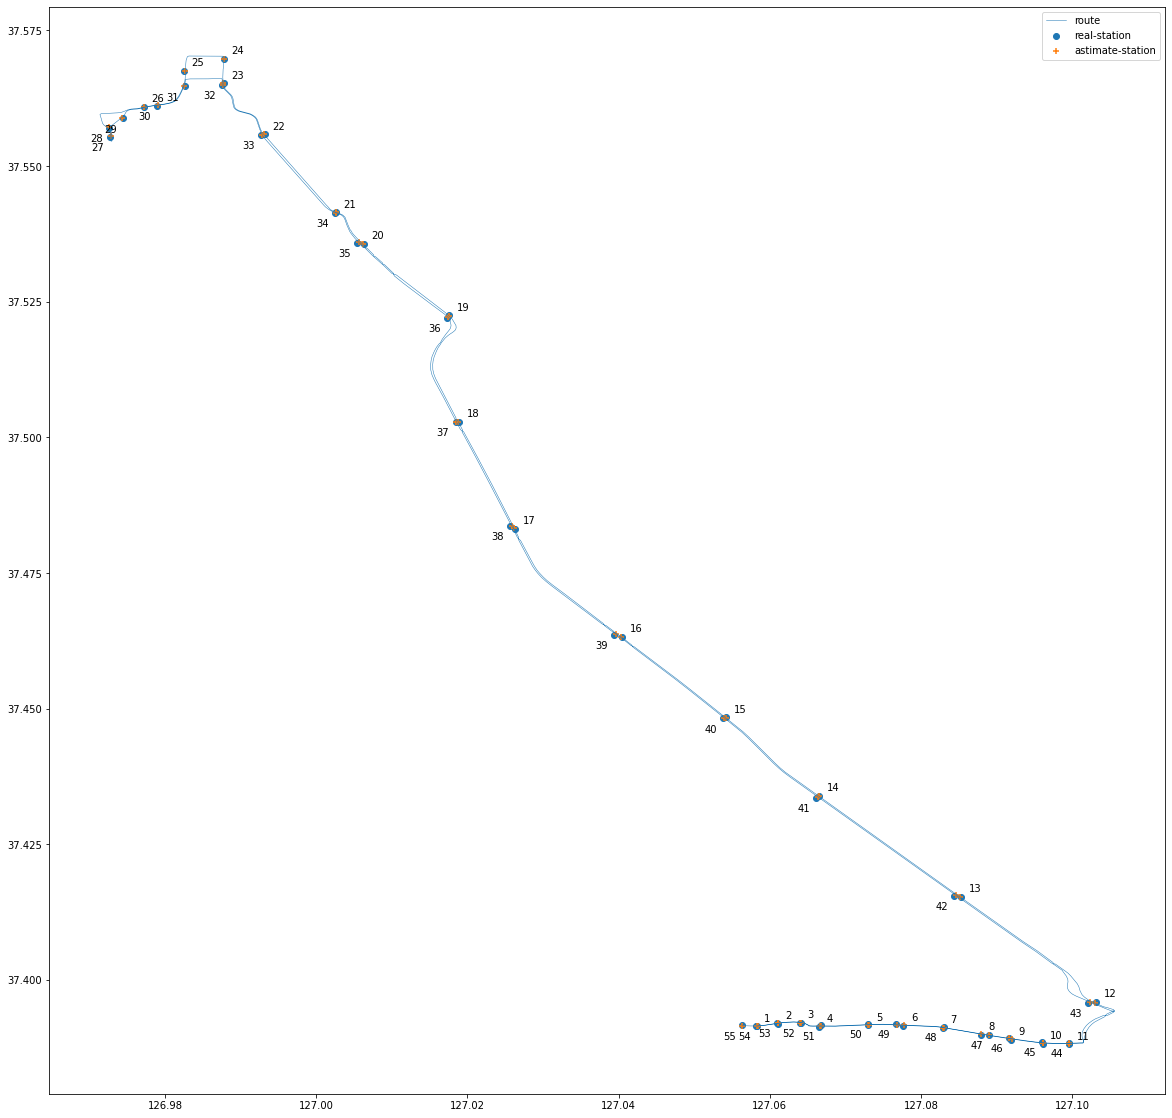

In [102]:
plt.figure(figsize=(20, 20))
lsx = df_line.iloc[stationIndexList]['x']
lsy = df_line.iloc[stationIndexList]['y']
sx = df_station['x']
sy = df_station['y']
lx = df_line['x']
ly = df_line['y']
plt.plot(lx, ly, linewidth='.5')
plt.scatter(sx, sy)
plt.scatter(lsx, lsy, marker = '+')
plt.legend(['route', 'real-station', 'astimate-station'])


for i in df_station.index:
    if(i < len(df_station)//2):
        sig = 1
    else:
        sig = -2.5
    plt.text(df_station['x'].iloc[i-1]+0.001*sig, df_station['y'].iloc[i-1]+0.001*sig, f'{i}')
plt.show()